In [1]:
!export CUDA_VISIBLE_DEVICES=0

In [2]:
import os, torch
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
print("CUDA_VISIBLE_DEVICES:", os.environ.get("CUDA_VISIBLE_DEVICES"))
print("Built with CUDA:", torch.version.cuda)     
print("CUDA available?:", torch.cuda.is_available())  
print("Device count:", torch.cuda.device_count())

CUDA_VISIBLE_DEVICES: 0
Built with CUDA: 12.4
CUDA available?: True
Device count: 1


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import nn
from semisupervised import SemiSupervisedAutoEncoderOptions, SemiSupervisedAdversarialAutoencoder

In [4]:
from torch.utils.data import random_split

def configure_mnist(batch_size=100, val_size=10000):
    # transform: ToTensor + flatten
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.view(-1))
    ])

    # full train + test datasets
    full_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_ds    = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    # split full_train → train_ds (60k - val_size) and val_ds (val_size)
    train_size = len(full_train) - val_size
    train_ds, val_ds = random_split(full_train, [train_size, val_size])

    # DataLoaders
    train_loader = DataLoader(train_ds,  batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

    # (Optionally) extract raw tensors:
    X_train = torch.stack([x for x, _ in train_ds])
    Y_train = torch.tensor([y for _, y in train_ds])
    X_val   = torch.stack([x for x, _ in val_ds])
    Y_val   = torch.tensor([y for _, y in val_ds])
    X_test  = torch.stack([x for x, _ in test_ds])
    Y_test  = test_ds.targets.clone()

    return (X_train, X_val, X_test,
            Y_train, Y_val, Y_test,
            train_loader, val_loader, test_loader)

In [5]:
(X_train, X_val, X_test, Y_train, Y_val, Y_test, train_loader, val_loader, test_loader) = configure_mnist()

print(Y_train.max())
print(Y_train.min())

tensor(9)
tensor(0)


In [4]:
NUM_EPOCHS = 300
INPUT_DIM = 784
BATCH_SIZE = 100
AE_HIDDEN = 1000
DC_HIDDEN = 1000
LATENT_DIM_CAT = 10
LATENT_DIM_STYLE = 10
PRIOR_STD = 1.0

recon_loss = nn.MSELoss()
init_recon_lr = 0.001 #0.01

semi_sup_loss = nn.CrossEntropyLoss()
init_semi_sup_lr = 0.001 #0.1

init_gen_lr = init_disc_lr = 0.001 #0.1
use_decoder_sigmoid = True

In [5]:
options = SemiSupervisedAutoEncoderOptions(
    input_dim=INPUT_DIM,
    ae_hidden_dim=AE_HIDDEN,
    disc_hidden_dim=DC_HIDDEN,
    latent_dim_categorical=LATENT_DIM_CAT,
    latent_dim_style=LATENT_DIM_STYLE,
    recon_loss_fn=recon_loss,
    init_recon_lr=init_recon_lr,
    semi_supervised_loss_fn=semi_sup_loss,
    init_semi_sup_lr=init_semi_sup_lr,
    init_gen_lr=init_gen_lr,
    use_decoder_sigmoid=use_decoder_sigmoid,
    init_disc_categorical_lr = init_disc_lr,
    init_disc_style_lr = init_disc_lr
)

model = SemiSupervisedAdversarialAutoencoder(options);

In [9]:
model.train_mbgd(
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=NUM_EPOCHS,
    prior_std=PRIOR_STD,
    result_folder="semisupervised_results/300_epochs_adam_results"
)

Epoch [1/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1/300 — Recon: 0.0612, Disc_Cat: 0.3863, Gen_Cat: 4.7761, Disc_Style: 0.4202, Gen_Style: 4.0133, SemiSup: 3.9085
Validation Accuracy: 29.31%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [2/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 2/300 — Recon: 0.0384, Disc_Cat: 0.7342, Gen_Cat: 4.3829, Disc_Style: 0.5188, Gen_Style: 3.9642, SemiSup: 2.1183
Validation Accuracy: 83.20%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [3/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 3/300 — Recon: 0.0269, Disc_Cat: 1.2160, Gen_Cat: 2.1005, Disc_Style: 0.9221, Gen_Style: 1.8681, SemiSup: 0.5172
Validation Accuracy: 91.66%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [4/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 4/300 — Recon: 0.0220, Disc_Cat: 1.2514, Gen_Cat: 1.6221, Disc_Style: 1.0677, Gen_Style: 1.3401, SemiSup: 0.3741
Validation Accuracy: 93.29%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [5/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 5/300 — Recon: 0.0203, Disc_Cat: 1.2588, Gen_Cat: 1.4991, Disc_Style: 1.1353, Gen_Style: 1.1472, SemiSup: 0.3098
Validation Accuracy: 93.94%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [6/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 6/300 — Recon: 0.0193, Disc_Cat: 1.2694, Gen_Cat: 1.3502, Disc_Style: 1.2035, Gen_Style: 1.0591, SemiSup: 0.2781
Validation Accuracy: 94.60%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [7/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 7/300 — Recon: 0.0185, Disc_Cat: 1.2801, Gen_Cat: 1.2553, Disc_Style: 1.2436, Gen_Style: 0.9934, SemiSup: 0.2581
Validation Accuracy: 94.82%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [8/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 8/300 — Recon: 0.0178, Disc_Cat: 1.2922, Gen_Cat: 1.1603, Disc_Style: 1.2685, Gen_Style: 0.9349, SemiSup: 0.2226
Validation Accuracy: 94.74%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [9/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 9/300 — Recon: 0.0173, Disc_Cat: 1.2985, Gen_Cat: 1.0895, Disc_Style: 1.2840, Gen_Style: 0.9045, SemiSup: 0.1995
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [10/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 10/300 — Recon: 0.0173, Disc_Cat: 1.3056, Gen_Cat: 1.0340, Disc_Style: 1.3083, Gen_Style: 0.8827, SemiSup: 0.1829
Validation Accuracy: 95.70%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [11/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 11/300 — Recon: 0.0167, Disc_Cat: 1.3099, Gen_Cat: 0.9961, Disc_Style: 1.3112, Gen_Style: 0.8687, SemiSup: 0.1705
Validation Accuracy: 95.90%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [12/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 12/300 — Recon: 0.0164, Disc_Cat: 1.3156, Gen_Cat: 0.9695, Disc_Style: 1.3268, Gen_Style: 0.8370, SemiSup: 0.1644
Validation Accuracy: 95.78%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [13/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 13/300 — Recon: 0.0164, Disc_Cat: 1.3164, Gen_Cat: 0.9630, Disc_Style: 1.3325, Gen_Style: 0.8306, SemiSup: 0.1590
Validation Accuracy: 96.23%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [14/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 14/300 — Recon: 0.0161, Disc_Cat: 1.3213, Gen_Cat: 0.9446, Disc_Style: 1.3367, Gen_Style: 0.8020, SemiSup: 0.1530
Validation Accuracy: 95.87%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [15/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 15/300 — Recon: 0.0161, Disc_Cat: 1.3259, Gen_Cat: 0.9127, Disc_Style: 1.3500, Gen_Style: 0.8091, SemiSup: 0.1502
Validation Accuracy: 96.17%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [16/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 16/300 — Recon: 0.0160, Disc_Cat: 1.3287, Gen_Cat: 0.9028, Disc_Style: 1.3548, Gen_Style: 0.7935, SemiSup: 0.1425
Validation Accuracy: 96.23%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [17/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 17/300 — Recon: 0.0157, Disc_Cat: 1.3305, Gen_Cat: 0.8986, Disc_Style: 1.3586, Gen_Style: 0.7760, SemiSup: 0.1415
Validation Accuracy: 96.25%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [18/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 18/300 — Recon: 0.0155, Disc_Cat: 1.3310, Gen_Cat: 0.8935, Disc_Style: 1.3664, Gen_Style: 0.7606, SemiSup: 0.1366
Validation Accuracy: 96.65%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [19/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 19/300 — Recon: 0.0154, Disc_Cat: 1.3343, Gen_Cat: 0.8844, Disc_Style: 1.3694, Gen_Style: 0.7491, SemiSup: 0.1287
Validation Accuracy: 96.44%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [20/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 20/300 — Recon: 0.0152, Disc_Cat: 1.3353, Gen_Cat: 0.8795, Disc_Style: 1.3766, Gen_Style: 0.7406, SemiSup: 0.1267
Validation Accuracy: 96.42%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [21/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 21/300 — Recon: 0.0152, Disc_Cat: 1.3346, Gen_Cat: 0.8849, Disc_Style: 1.3738, Gen_Style: 0.7376, SemiSup: 0.1223
Validation Accuracy: 96.33%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [22/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 22/300 — Recon: 0.0150, Disc_Cat: 1.3384, Gen_Cat: 0.8644, Disc_Style: 1.3778, Gen_Style: 0.7294, SemiSup: 0.1179
Validation Accuracy: 96.71%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [23/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 23/300 — Recon: 0.0151, Disc_Cat: 1.3370, Gen_Cat: 0.8768, Disc_Style: 1.3819, Gen_Style: 0.7249, SemiSup: 0.1168
Validation Accuracy: 96.33%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [24/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 24/300 — Recon: 0.0149, Disc_Cat: 1.3374, Gen_Cat: 0.8737, Disc_Style: 1.3818, Gen_Style: 0.7254, SemiSup: 0.1171
Validation Accuracy: 96.75%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [25/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 25/300 — Recon: 0.0143, Disc_Cat: 1.3393, Gen_Cat: 0.8788, Disc_Style: 1.3829, Gen_Style: 0.7125, SemiSup: 0.1077
Validation Accuracy: 96.66%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [26/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 26/300 — Recon: 0.0148, Disc_Cat: 1.3371, Gen_Cat: 0.8848, Disc_Style: 1.3856, Gen_Style: 0.7142, SemiSup: 0.1082
Validation Accuracy: 96.81%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [27/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 27/300 — Recon: 0.0142, Disc_Cat: 1.3395, Gen_Cat: 0.8851, Disc_Style: 1.3847, Gen_Style: 0.7086, SemiSup: 0.1016
Validation Accuracy: 96.84%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [28/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 28/300 — Recon: 0.0146, Disc_Cat: 1.3393, Gen_Cat: 0.9042, Disc_Style: 1.3871, Gen_Style: 0.7081, SemiSup: 0.1043
Validation Accuracy: 96.51%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [29/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 29/300 — Recon: 0.0151, Disc_Cat: 1.3395, Gen_Cat: 0.9345, Disc_Style: 1.3867, Gen_Style: 0.7095, SemiSup: 0.1073
Validation Accuracy: 96.98%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [30/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 30/300 — Recon: 0.0141, Disc_Cat: 1.3413, Gen_Cat: 0.9437, Disc_Style: 1.3861, Gen_Style: 0.7078, SemiSup: 0.1070
Validation Accuracy: 96.78%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [31/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 31/300 — Recon: 0.0148, Disc_Cat: 1.3396, Gen_Cat: 0.9717, Disc_Style: 1.3894, Gen_Style: 0.7075, SemiSup: 0.1050
Validation Accuracy: 96.89%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [32/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 32/300 — Recon: 0.0137, Disc_Cat: 1.3416, Gen_Cat: 0.9743, Disc_Style: 1.3870, Gen_Style: 0.7010, SemiSup: 0.0901
Validation Accuracy: 96.83%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [33/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 33/300 — Recon: 0.0142, Disc_Cat: 1.3404, Gen_Cat: 1.0040, Disc_Style: 1.3868, Gen_Style: 0.7006, SemiSup: 0.0960
Validation Accuracy: 96.72%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [34/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 34/300 — Recon: 0.0135, Disc_Cat: 1.3445, Gen_Cat: 0.9958, Disc_Style: 1.3873, Gen_Style: 0.6990, SemiSup: 0.0925
Validation Accuracy: 97.06%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [35/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 35/300 — Recon: 0.0137, Disc_Cat: 1.3424, Gen_Cat: 1.0247, Disc_Style: 1.3870, Gen_Style: 0.6988, SemiSup: 0.0913
Validation Accuracy: 96.97%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [36/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 36/300 — Recon: 0.0138, Disc_Cat: 1.3423, Gen_Cat: 1.0345, Disc_Style: 1.3883, Gen_Style: 0.6978, SemiSup: 0.0872
Validation Accuracy: 97.21%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [37/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 37/300 — Recon: 0.0135, Disc_Cat: 1.3416, Gen_Cat: 1.0611, Disc_Style: 1.3879, Gen_Style: 0.6974, SemiSup: 0.0816
Validation Accuracy: 97.02%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [38/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 38/300 — Recon: 0.0143, Disc_Cat: 1.3391, Gen_Cat: 1.1061, Disc_Style: 1.3893, Gen_Style: 0.6993, SemiSup: 0.0881
Validation Accuracy: 97.04%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [39/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 39/300 — Recon: 0.0125, Disc_Cat: 1.3454, Gen_Cat: 1.0596, Disc_Style: 1.3864, Gen_Style: 0.6940, SemiSup: 0.0785
Validation Accuracy: 97.30%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [40/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 40/300 — Recon: 0.0133, Disc_Cat: 1.3430, Gen_Cat: 1.0941, Disc_Style: 1.3874, Gen_Style: 0.6957, SemiSup: 0.0819
Validation Accuracy: 96.79%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [41/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 41/300 — Recon: 0.0134, Disc_Cat: 1.3439, Gen_Cat: 1.1064, Disc_Style: 1.3886, Gen_Style: 0.6954, SemiSup: 0.0790
Validation Accuracy: 96.91%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [42/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 42/300 — Recon: 0.0132, Disc_Cat: 1.3432, Gen_Cat: 1.1382, Disc_Style: 1.3876, Gen_Style: 0.6951, SemiSup: 0.0700
Validation Accuracy: 96.92%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [43/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 43/300 — Recon: 0.0125, Disc_Cat: 1.3436, Gen_Cat: 1.1579, Disc_Style: 1.3866, Gen_Style: 0.6942, SemiSup: 0.0706
Validation Accuracy: 97.29%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [44/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 44/300 — Recon: 0.0247, Disc_Cat: 1.2866, Gen_Cat: 1.8962, Disc_Style: 1.4289, Gen_Style: 0.7941, SemiSup: 0.2417
Validation Accuracy: 96.23%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [45/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 45/300 — Recon: 0.0168, Disc_Cat: 1.3241, Gen_Cat: 1.4940, Disc_Style: 1.4050, Gen_Style: 0.7593, SemiSup: 0.1280
Validation Accuracy: 96.94%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [46/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 46/300 — Recon: 0.0133, Disc_Cat: 1.3399, Gen_Cat: 1.2889, Disc_Style: 1.3862, Gen_Style: 0.6995, SemiSup: 0.0896
Validation Accuracy: 96.79%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [47/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 47/300 — Recon: 0.0123, Disc_Cat: 1.3420, Gen_Cat: 1.2802, Disc_Style: 1.3862, Gen_Style: 0.6943, SemiSup: 0.0745
Validation Accuracy: 97.30%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [48/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 48/300 — Recon: 0.0121, Disc_Cat: 1.3424, Gen_Cat: 1.3067, Disc_Style: 1.3861, Gen_Style: 0.6936, SemiSup: 0.0720
Validation Accuracy: 97.41%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [49/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 49/300 — Recon: 0.0122, Disc_Cat: 1.3434, Gen_Cat: 1.2849, Disc_Style: 1.3865, Gen_Style: 0.6941, SemiSup: 0.0706
Validation Accuracy: 97.23%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [50/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 50/300 — Recon: 0.0120, Disc_Cat: 1.3439, Gen_Cat: 1.2839, Disc_Style: 1.3862, Gen_Style: 0.6940, SemiSup: 0.0681
Validation Accuracy: 97.30%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [51/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 51/300 — Recon: 0.0110, Disc_Cat: 1.3475, Gen_Cat: 1.2006, Disc_Style: 1.3859, Gen_Style: 0.6921, SemiSup: 0.0463
Validation Accuracy: 97.47%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [52/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 52/300 — Recon: 0.0108, Disc_Cat: 1.3447, Gen_Cat: 1.2376, Disc_Style: 1.3859, Gen_Style: 0.6924, SemiSup: 0.0389
Validation Accuracy: 97.35%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [53/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 53/300 — Recon: 0.0107, Disc_Cat: 1.3431, Gen_Cat: 1.2677, Disc_Style: 1.3861, Gen_Style: 0.6938, SemiSup: 0.0386
Validation Accuracy: 97.49%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [54/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 54/300 — Recon: 0.0107, Disc_Cat: 1.3414, Gen_Cat: 1.2907, Disc_Style: 1.3865, Gen_Style: 0.6931, SemiSup: 0.0372
Validation Accuracy: 97.45%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [55/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 55/300 — Recon: 0.0109, Disc_Cat: 1.3397, Gen_Cat: 1.3102, Disc_Style: 1.3857, Gen_Style: 0.6970, SemiSup: 0.0377
Validation Accuracy: 97.55%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [56/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 56/300 — Recon: 0.0110, Disc_Cat: 1.3404, Gen_Cat: 1.3144, Disc_Style: 1.3853, Gen_Style: 0.6930, SemiSup: 0.0404
Validation Accuracy: 97.38%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [57/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 57/300 — Recon: 0.0111, Disc_Cat: 1.3395, Gen_Cat: 1.3467, Disc_Style: 1.3848, Gen_Style: 0.6945, SemiSup: 0.0414
Validation Accuracy: 97.51%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [58/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 58/300 — Recon: 0.0111, Disc_Cat: 1.3375, Gen_Cat: 1.3679, Disc_Style: 1.3844, Gen_Style: 0.6948, SemiSup: 0.0409
Validation Accuracy: 97.48%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [59/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 59/300 — Recon: 0.0112, Disc_Cat: 1.3389, Gen_Cat: 1.3796, Disc_Style: 1.3853, Gen_Style: 0.6958, SemiSup: 0.0402
Validation Accuracy: 97.44%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [60/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 60/300 — Recon: 0.0112, Disc_Cat: 1.3369, Gen_Cat: 1.4096, Disc_Style: 1.3839, Gen_Style: 0.6959, SemiSup: 0.0400
Validation Accuracy: 97.52%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [61/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 61/300 — Recon: 0.0113, Disc_Cat: 1.3364, Gen_Cat: 1.4242, Disc_Style: 1.3841, Gen_Style: 0.6946, SemiSup: 0.0391
Validation Accuracy: 97.35%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [62/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 62/300 — Recon: 0.0113, Disc_Cat: 1.3341, Gen_Cat: 1.4621, Disc_Style: 1.3843, Gen_Style: 0.6979, SemiSup: 0.0416
Validation Accuracy: 97.37%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [63/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 63/300 — Recon: 0.0111, Disc_Cat: 1.3347, Gen_Cat: 1.4662, Disc_Style: 1.3841, Gen_Style: 0.6941, SemiSup: 0.0380
Validation Accuracy: 97.53%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [64/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 64/300 — Recon: 0.0109, Disc_Cat: 1.3373, Gen_Cat: 1.4403, Disc_Style: 1.3851, Gen_Style: 0.6951, SemiSup: 0.0384
Validation Accuracy: 97.45%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [65/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 65/300 — Recon: 0.0108, Disc_Cat: 1.3388, Gen_Cat: 1.4409, Disc_Style: 1.3848, Gen_Style: 0.6939, SemiSup: 0.0372
Validation Accuracy: 97.46%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [66/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 66/300 — Recon: 0.0110, Disc_Cat: 1.3370, Gen_Cat: 1.4773, Disc_Style: 1.3833, Gen_Style: 0.6981, SemiSup: 0.0375
Validation Accuracy: 97.49%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [67/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 67/300 — Recon: 0.0110, Disc_Cat: 1.3367, Gen_Cat: 1.4961, Disc_Style: 1.3839, Gen_Style: 0.6964, SemiSup: 0.0369
Validation Accuracy: 97.45%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [68/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 68/300 — Recon: 0.0113, Disc_Cat: 1.3380, Gen_Cat: 1.5163, Disc_Style: 1.3829, Gen_Style: 0.6994, SemiSup: 0.0389
Validation Accuracy: 97.60%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [69/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 69/300 — Recon: 0.0112, Disc_Cat: 1.3372, Gen_Cat: 1.5405, Disc_Style: 1.3833, Gen_Style: 0.6956, SemiSup: 0.0386
Validation Accuracy: 97.41%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [70/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 70/300 — Recon: 0.0111, Disc_Cat: 1.3377, Gen_Cat: 1.5389, Disc_Style: 1.3830, Gen_Style: 0.6962, SemiSup: 0.0365
Validation Accuracy: 97.43%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [71/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 71/300 — Recon: 0.0111, Disc_Cat: 1.3359, Gen_Cat: 1.5723, Disc_Style: 1.3803, Gen_Style: 0.7021, SemiSup: 0.0363
Validation Accuracy: 97.40%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [72/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 72/300 — Recon: 0.0114, Disc_Cat: 1.3364, Gen_Cat: 1.5897, Disc_Style: 1.3802, Gen_Style: 0.7040, SemiSup: 0.0376
Validation Accuracy: 97.43%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [73/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 73/300 — Recon: 0.0111, Disc_Cat: 1.3371, Gen_Cat: 1.5793, Disc_Style: 1.3820, Gen_Style: 0.6948, SemiSup: 0.0370
Validation Accuracy: 97.44%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [74/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 74/300 — Recon: 0.0110, Disc_Cat: 1.3389, Gen_Cat: 1.5631, Disc_Style: 1.3805, Gen_Style: 0.6995, SemiSup: 0.0372
Validation Accuracy: 97.38%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [75/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 75/300 — Recon: 0.0111, Disc_Cat: 1.3388, Gen_Cat: 1.5761, Disc_Style: 1.3772, Gen_Style: 0.7030, SemiSup: 0.0385
Validation Accuracy: 97.47%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [76/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 76/300 — Recon: 0.0112, Disc_Cat: 1.3374, Gen_Cat: 1.6306, Disc_Style: 1.3774, Gen_Style: 0.7046, SemiSup: 0.0389
Validation Accuracy: 97.55%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [77/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 77/300 — Recon: 0.0111, Disc_Cat: 1.3373, Gen_Cat: 1.6250, Disc_Style: 1.3782, Gen_Style: 0.6990, SemiSup: 0.0370
Validation Accuracy: 97.46%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [78/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 78/300 — Recon: 0.0110, Disc_Cat: 1.3385, Gen_Cat: 1.6320, Disc_Style: 1.3777, Gen_Style: 0.7088, SemiSup: 0.0367
Validation Accuracy: 97.48%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [79/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 79/300 — Recon: 0.0111, Disc_Cat: 1.3375, Gen_Cat: 1.6556, Disc_Style: 1.3770, Gen_Style: 0.7095, SemiSup: 0.0360
Validation Accuracy: 97.45%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [80/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 80/300 — Recon: 0.0111, Disc_Cat: 1.3391, Gen_Cat: 1.6417, Disc_Style: 1.3768, Gen_Style: 0.7019, SemiSup: 0.0357
Validation Accuracy: 97.46%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [81/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 81/300 — Recon: 0.0113, Disc_Cat: 1.3384, Gen_Cat: 1.6727, Disc_Style: 1.3762, Gen_Style: 0.7156, SemiSup: 0.0362
Validation Accuracy: 97.48%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [82/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 82/300 — Recon: 0.0111, Disc_Cat: 1.3366, Gen_Cat: 1.6830, Disc_Style: 1.3720, Gen_Style: 0.7122, SemiSup: 0.0347
Validation Accuracy: 97.47%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [83/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 83/300 — Recon: 0.0111, Disc_Cat: 1.3381, Gen_Cat: 1.6779, Disc_Style: 1.3725, Gen_Style: 0.7142, SemiSup: 0.0372
Validation Accuracy: 97.45%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [84/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 84/300 — Recon: 0.0111, Disc_Cat: 1.3372, Gen_Cat: 1.7073, Disc_Style: 1.3715, Gen_Style: 0.7142, SemiSup: 0.0351
Validation Accuracy: 97.56%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [85/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 85/300 — Recon: 0.0112, Disc_Cat: 1.3378, Gen_Cat: 1.7102, Disc_Style: 1.3718, Gen_Style: 0.7157, SemiSup: 0.0358
Validation Accuracy: 97.48%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [86/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 86/300 — Recon: 0.0112, Disc_Cat: 1.3385, Gen_Cat: 1.7294, Disc_Style: 1.3694, Gen_Style: 0.7188, SemiSup: 0.0349
Validation Accuracy: 97.53%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [87/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 87/300 — Recon: 0.0112, Disc_Cat: 1.3385, Gen_Cat: 1.7439, Disc_Style: 1.3681, Gen_Style: 0.7171, SemiSup: 0.0356
Validation Accuracy: 97.40%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [88/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 88/300 — Recon: 0.0112, Disc_Cat: 1.3391, Gen_Cat: 1.7393, Disc_Style: 1.3634, Gen_Style: 0.7281, SemiSup: 0.0349
Validation Accuracy: 97.50%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [89/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 89/300 — Recon: 0.0112, Disc_Cat: 1.3364, Gen_Cat: 1.7639, Disc_Style: 1.3619, Gen_Style: 0.7241, SemiSup: 0.0351
Validation Accuracy: 97.41%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [90/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 90/300 — Recon: 0.0113, Disc_Cat: 1.3369, Gen_Cat: 1.7853, Disc_Style: 1.3625, Gen_Style: 0.7270, SemiSup: 0.0364
Validation Accuracy: 97.43%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [91/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 91/300 — Recon: 0.0113, Disc_Cat: 1.3390, Gen_Cat: 1.7816, Disc_Style: 1.3668, Gen_Style: 0.7344, SemiSup: 0.0352
Validation Accuracy: 97.50%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [92/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 92/300 — Recon: 0.0112, Disc_Cat: 1.3377, Gen_Cat: 1.8013, Disc_Style: 1.3658, Gen_Style: 0.7279, SemiSup: 0.0345
Validation Accuracy: 97.50%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [93/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 93/300 — Recon: 0.0111, Disc_Cat: 1.3364, Gen_Cat: 1.8136, Disc_Style: 1.3625, Gen_Style: 0.7286, SemiSup: 0.0344
Validation Accuracy: 97.53%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [94/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 94/300 — Recon: 0.0111, Disc_Cat: 1.3390, Gen_Cat: 1.8054, Disc_Style: 1.3638, Gen_Style: 0.7288, SemiSup: 0.0341
Validation Accuracy: 97.46%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [95/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 95/300 — Recon: 0.0110, Disc_Cat: 1.3391, Gen_Cat: 1.8023, Disc_Style: 1.3608, Gen_Style: 0.7290, SemiSup: 0.0326
Validation Accuracy: 97.44%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [96/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 96/300 — Recon: 0.0110, Disc_Cat: 1.3394, Gen_Cat: 1.8021, Disc_Style: 1.3586, Gen_Style: 0.7309, SemiSup: 0.0322
Validation Accuracy: 97.32%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [97/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 97/300 — Recon: 0.0111, Disc_Cat: 1.3365, Gen_Cat: 1.8463, Disc_Style: 1.3635, Gen_Style: 0.7304, SemiSup: 0.0322
Validation Accuracy: 97.40%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [98/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 98/300 — Recon: 0.0111, Disc_Cat: 1.3375, Gen_Cat: 1.8459, Disc_Style: 1.3621, Gen_Style: 0.7290, SemiSup: 0.0317
Validation Accuracy: 97.46%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [99/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 99/300 — Recon: 0.0111, Disc_Cat: 1.3390, Gen_Cat: 1.8379, Disc_Style: 1.3587, Gen_Style: 0.7338, SemiSup: 0.0322
Validation Accuracy: 97.43%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [100/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 100/300 — Recon: 0.0111, Disc_Cat: 1.3378, Gen_Cat: 1.8535, Disc_Style: 1.3605, Gen_Style: 0.7274, SemiSup: 0.0324
Validation Accuracy: 97.45%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [101/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 101/300 — Recon: 0.0110, Disc_Cat: 1.3382, Gen_Cat: 1.8566, Disc_Style: 1.3600, Gen_Style: 0.7277, SemiSup: 0.0324
Validation Accuracy: 97.44%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [102/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 102/300 — Recon: 0.0110, Disc_Cat: 1.3379, Gen_Cat: 1.8702, Disc_Style: 1.3590, Gen_Style: 0.7329, SemiSup: 0.0310
Validation Accuracy: 97.45%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [103/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 103/300 — Recon: 0.0110, Disc_Cat: 1.3390, Gen_Cat: 1.8725, Disc_Style: 1.3604, Gen_Style: 0.7305, SemiSup: 0.0313
Validation Accuracy: 97.40%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [104/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 104/300 — Recon: 0.0110, Disc_Cat: 1.3410, Gen_Cat: 1.8492, Disc_Style: 1.3621, Gen_Style: 0.7285, SemiSup: 0.0312
Validation Accuracy: 97.32%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [105/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 105/300 — Recon: 0.0110, Disc_Cat: 1.3412, Gen_Cat: 1.8564, Disc_Style: 1.3628, Gen_Style: 0.7294, SemiSup: 0.0314
Validation Accuracy: 97.49%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [106/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 106/300 — Recon: 0.0110, Disc_Cat: 1.3392, Gen_Cat: 1.8783, Disc_Style: 1.3612, Gen_Style: 0.7312, SemiSup: 0.0315
Validation Accuracy: 97.40%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [107/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 107/300 — Recon: 0.0110, Disc_Cat: 1.3387, Gen_Cat: 1.8923, Disc_Style: 1.3635, Gen_Style: 0.7282, SemiSup: 0.0308
Validation Accuracy: 97.34%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [108/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 108/300 — Recon: 0.0110, Disc_Cat: 1.3389, Gen_Cat: 1.8875, Disc_Style: 1.3638, Gen_Style: 0.7271, SemiSup: 0.0309
Validation Accuracy: 97.41%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [109/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 109/300 — Recon: 0.0109, Disc_Cat: 1.3405, Gen_Cat: 1.8806, Disc_Style: 1.3627, Gen_Style: 0.7272, SemiSup: 0.0309
Validation Accuracy: 97.40%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [110/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 110/300 — Recon: 0.0110, Disc_Cat: 1.3401, Gen_Cat: 1.9001, Disc_Style: 1.3631, Gen_Style: 0.7283, SemiSup: 0.0304
Validation Accuracy: 97.35%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [111/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 111/300 — Recon: 0.0110, Disc_Cat: 1.3404, Gen_Cat: 1.8991, Disc_Style: 1.3618, Gen_Style: 0.7279, SemiSup: 0.0304
Validation Accuracy: 97.45%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [112/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 112/300 — Recon: 0.0110, Disc_Cat: 1.3416, Gen_Cat: 1.8852, Disc_Style: 1.3597, Gen_Style: 0.7296, SemiSup: 0.0309
Validation Accuracy: 97.42%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [113/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 113/300 — Recon: 0.0110, Disc_Cat: 1.3402, Gen_Cat: 1.9201, Disc_Style: 1.3610, Gen_Style: 0.7274, SemiSup: 0.0306
Validation Accuracy: 97.41%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [114/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 114/300 — Recon: 0.0110, Disc_Cat: 1.3411, Gen_Cat: 1.9177, Disc_Style: 1.3617, Gen_Style: 0.7285, SemiSup: 0.0297
Validation Accuracy: 97.41%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [115/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 115/300 — Recon: 0.0109, Disc_Cat: 1.3416, Gen_Cat: 1.9266, Disc_Style: 1.3655, Gen_Style: 0.7275, SemiSup: 0.0299
Validation Accuracy: 97.43%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [116/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 116/300 — Recon: 0.0109, Disc_Cat: 1.3393, Gen_Cat: 1.9263, Disc_Style: 1.3658, Gen_Style: 0.7256, SemiSup: 0.0297
Validation Accuracy: 97.45%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [117/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 117/300 — Recon: 0.0109, Disc_Cat: 1.3414, Gen_Cat: 1.9195, Disc_Style: 1.3635, Gen_Style: 0.7259, SemiSup: 0.0283
Validation Accuracy: 97.44%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [118/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 118/300 — Recon: 0.0109, Disc_Cat: 1.3411, Gen_Cat: 1.9269, Disc_Style: 1.3622, Gen_Style: 0.7252, SemiSup: 0.0295
Validation Accuracy: 97.42%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [119/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 119/300 — Recon: 0.0109, Disc_Cat: 1.3422, Gen_Cat: 1.9263, Disc_Style: 1.3622, Gen_Style: 0.7272, SemiSup: 0.0292
Validation Accuracy: 97.43%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [120/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 120/300 — Recon: 0.0109, Disc_Cat: 1.3394, Gen_Cat: 1.9444, Disc_Style: 1.3625, Gen_Style: 0.7270, SemiSup: 0.0286
Validation Accuracy: 97.50%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [121/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 121/300 — Recon: 0.0109, Disc_Cat: 1.3417, Gen_Cat: 1.9405, Disc_Style: 1.3636, Gen_Style: 0.7277, SemiSup: 0.0285
Validation Accuracy: 97.52%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [122/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 122/300 — Recon: 0.0109, Disc_Cat: 1.3391, Gen_Cat: 1.9702, Disc_Style: 1.3643, Gen_Style: 0.7260, SemiSup: 0.0284
Validation Accuracy: 97.40%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [123/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 123/300 — Recon: 0.0109, Disc_Cat: 1.3414, Gen_Cat: 1.9675, Disc_Style: 1.3631, Gen_Style: 0.7271, SemiSup: 0.0288
Validation Accuracy: 97.41%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [124/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 124/300 — Recon: 0.0109, Disc_Cat: 1.3395, Gen_Cat: 1.9959, Disc_Style: 1.3655, Gen_Style: 0.7262, SemiSup: 0.0280
Validation Accuracy: 97.52%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [125/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 125/300 — Recon: 0.0109, Disc_Cat: 1.3427, Gen_Cat: 1.9659, Disc_Style: 1.3638, Gen_Style: 0.7287, SemiSup: 0.0284
Validation Accuracy: 97.42%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [126/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 126/300 — Recon: 0.0108, Disc_Cat: 1.3415, Gen_Cat: 1.9720, Disc_Style: 1.3621, Gen_Style: 0.7288, SemiSup: 0.0276
Validation Accuracy: 97.40%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [127/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 127/300 — Recon: 0.0108, Disc_Cat: 1.3400, Gen_Cat: 1.9877, Disc_Style: 1.3621, Gen_Style: 0.7264, SemiSup: 0.0275
Validation Accuracy: 97.46%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [128/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 128/300 — Recon: 0.0108, Disc_Cat: 1.3397, Gen_Cat: 1.9977, Disc_Style: 1.3631, Gen_Style: 0.7254, SemiSup: 0.0276
Validation Accuracy: 97.49%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [129/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 129/300 — Recon: 0.0108, Disc_Cat: 1.3398, Gen_Cat: 2.0087, Disc_Style: 1.3624, Gen_Style: 0.7269, SemiSup: 0.0270
Validation Accuracy: 97.47%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [130/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 130/300 — Recon: 0.0108, Disc_Cat: 1.3423, Gen_Cat: 1.9756, Disc_Style: 1.3594, Gen_Style: 0.7316, SemiSup: 0.0274
Validation Accuracy: 97.48%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [131/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 131/300 — Recon: 0.0108, Disc_Cat: 1.3407, Gen_Cat: 2.0021, Disc_Style: 1.3612, Gen_Style: 0.7319, SemiSup: 0.0269
Validation Accuracy: 97.51%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [132/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 132/300 — Recon: 0.0109, Disc_Cat: 1.3403, Gen_Cat: 2.0307, Disc_Style: 1.3634, Gen_Style: 0.7298, SemiSup: 0.0268
Validation Accuracy: 97.45%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [133/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 133/300 — Recon: 0.0108, Disc_Cat: 1.3410, Gen_Cat: 2.0137, Disc_Style: 1.3617, Gen_Style: 0.7289, SemiSup: 0.0264
Validation Accuracy: 97.39%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [134/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 134/300 — Recon: 0.0108, Disc_Cat: 1.3404, Gen_Cat: 2.0579, Disc_Style: 1.3594, Gen_Style: 0.7296, SemiSup: 0.0262
Validation Accuracy: 97.47%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [135/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 135/300 — Recon: 0.0108, Disc_Cat: 1.3411, Gen_Cat: 2.0294, Disc_Style: 1.3606, Gen_Style: 0.7294, SemiSup: 0.0269
Validation Accuracy: 97.37%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [136/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 136/300 — Recon: 0.0108, Disc_Cat: 1.3414, Gen_Cat: 2.0218, Disc_Style: 1.3579, Gen_Style: 0.7301, SemiSup: 0.0263
Validation Accuracy: 97.42%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [137/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 137/300 — Recon: 0.0108, Disc_Cat: 1.3414, Gen_Cat: 2.0330, Disc_Style: 1.3603, Gen_Style: 0.7353, SemiSup: 0.0265
Validation Accuracy: 97.43%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [138/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 138/300 — Recon: 0.0109, Disc_Cat: 1.3389, Gen_Cat: 2.0583, Disc_Style: 1.3600, Gen_Style: 0.7324, SemiSup: 0.0255
Validation Accuracy: 97.41%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [139/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 139/300 — Recon: 0.0109, Disc_Cat: 1.3418, Gen_Cat: 2.0673, Disc_Style: 1.3620, Gen_Style: 0.7297, SemiSup: 0.0268
Validation Accuracy: 97.40%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [140/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 140/300 — Recon: 0.0108, Disc_Cat: 1.3419, Gen_Cat: 2.0592, Disc_Style: 1.3602, Gen_Style: 0.7291, SemiSup: 0.0264
Validation Accuracy: 97.36%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [141/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 141/300 — Recon: 0.0108, Disc_Cat: 1.3423, Gen_Cat: 2.0437, Disc_Style: 1.3605, Gen_Style: 0.7307, SemiSup: 0.0253
Validation Accuracy: 97.40%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [142/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 142/300 — Recon: 0.0108, Disc_Cat: 1.3406, Gen_Cat: 2.0733, Disc_Style: 1.3581, Gen_Style: 0.7317, SemiSup: 0.0254
Validation Accuracy: 97.48%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [143/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 143/300 — Recon: 0.0108, Disc_Cat: 1.3411, Gen_Cat: 2.0629, Disc_Style: 1.3591, Gen_Style: 0.7324, SemiSup: 0.0254
Validation Accuracy: 97.34%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [144/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 144/300 — Recon: 0.0107, Disc_Cat: 1.3404, Gen_Cat: 2.0750, Disc_Style: 1.3583, Gen_Style: 0.7325, SemiSup: 0.0255
Validation Accuracy: 97.39%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [145/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 145/300 — Recon: 0.0107, Disc_Cat: 1.3411, Gen_Cat: 2.0802, Disc_Style: 1.3581, Gen_Style: 0.7337, SemiSup: 0.0247
Validation Accuracy: 97.37%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [146/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 146/300 — Recon: 0.0107, Disc_Cat: 1.3415, Gen_Cat: 2.0808, Disc_Style: 1.3588, Gen_Style: 0.7332, SemiSup: 0.0251
Validation Accuracy: 97.32%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [147/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 147/300 — Recon: 0.0107, Disc_Cat: 1.3415, Gen_Cat: 2.0775, Disc_Style: 1.3592, Gen_Style: 0.7299, SemiSup: 0.0247
Validation Accuracy: 97.43%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [148/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 148/300 — Recon: 0.0107, Disc_Cat: 1.3421, Gen_Cat: 2.0958, Disc_Style: 1.3584, Gen_Style: 0.7320, SemiSup: 0.0256
Validation Accuracy: 97.42%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [149/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 149/300 — Recon: 0.0107, Disc_Cat: 1.3406, Gen_Cat: 2.0976, Disc_Style: 1.3596, Gen_Style: 0.7319, SemiSup: 0.0242
Validation Accuracy: 97.35%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [150/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 150/300 — Recon: 0.0107, Disc_Cat: 1.3411, Gen_Cat: 2.1075, Disc_Style: 1.3619, Gen_Style: 0.7308, SemiSup: 0.0245
Validation Accuracy: 97.41%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [151/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 151/300 — Recon: 0.0107, Disc_Cat: 1.3410, Gen_Cat: 2.1143, Disc_Style: 1.3619, Gen_Style: 0.7308, SemiSup: 0.0246
Validation Accuracy: 97.46%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [152/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 152/300 — Recon: 0.0107, Disc_Cat: 1.3414, Gen_Cat: 2.1127, Disc_Style: 1.3607, Gen_Style: 0.7338, SemiSup: 0.0241
Validation Accuracy: 97.38%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [153/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 153/300 — Recon: 0.0107, Disc_Cat: 1.3401, Gen_Cat: 2.1425, Disc_Style: 1.3611, Gen_Style: 0.7315, SemiSup: 0.0243
Validation Accuracy: 97.47%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [154/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 154/300 — Recon: 0.0107, Disc_Cat: 1.3408, Gen_Cat: 2.1400, Disc_Style: 1.3602, Gen_Style: 0.7310, SemiSup: 0.0235
Validation Accuracy: 97.43%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [155/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 155/300 — Recon: 0.0107, Disc_Cat: 1.3405, Gen_Cat: 2.1516, Disc_Style: 1.3601, Gen_Style: 0.7342, SemiSup: 0.0242
Validation Accuracy: 97.48%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [156/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 156/300 — Recon: 0.0107, Disc_Cat: 1.3412, Gen_Cat: 2.1421, Disc_Style: 1.3607, Gen_Style: 0.7305, SemiSup: 0.0234
Validation Accuracy: 97.40%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [157/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 157/300 — Recon: 0.0107, Disc_Cat: 1.3384, Gen_Cat: 2.1657, Disc_Style: 1.3605, Gen_Style: 0.7313, SemiSup: 0.0240
Validation Accuracy: 97.41%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [158/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 158/300 — Recon: 0.0107, Disc_Cat: 1.3409, Gen_Cat: 2.1570, Disc_Style: 1.3586, Gen_Style: 0.7339, SemiSup: 0.0232
Validation Accuracy: 97.37%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [159/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 159/300 — Recon: 0.0107, Disc_Cat: 1.3414, Gen_Cat: 2.1585, Disc_Style: 1.3616, Gen_Style: 0.7316, SemiSup: 0.0236
Validation Accuracy: 97.47%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [160/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 160/300 — Recon: 0.0107, Disc_Cat: 1.3404, Gen_Cat: 2.1708, Disc_Style: 1.3578, Gen_Style: 0.7340, SemiSup: 0.0234
Validation Accuracy: 97.41%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [161/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 161/300 — Recon: 0.0106, Disc_Cat: 1.3420, Gen_Cat: 2.1640, Disc_Style: 1.3574, Gen_Style: 0.7336, SemiSup: 0.0233
Validation Accuracy: 97.43%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [162/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 162/300 — Recon: 0.0106, Disc_Cat: 1.3420, Gen_Cat: 2.1707, Disc_Style: 1.3602, Gen_Style: 0.7323, SemiSup: 0.0231
Validation Accuracy: 97.43%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [163/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 163/300 — Recon: 0.0106, Disc_Cat: 1.3436, Gen_Cat: 2.1501, Disc_Style: 1.3586, Gen_Style: 0.7330, SemiSup: 0.0231
Validation Accuracy: 97.43%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [164/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 164/300 — Recon: 0.0106, Disc_Cat: 1.3416, Gen_Cat: 2.1839, Disc_Style: 1.3584, Gen_Style: 0.7320, SemiSup: 0.0228
Validation Accuracy: 97.45%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [165/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 165/300 — Recon: 0.0106, Disc_Cat: 1.3396, Gen_Cat: 2.2039, Disc_Style: 1.3567, Gen_Style: 0.7321, SemiSup: 0.0225
Validation Accuracy: 97.44%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [166/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 166/300 — Recon: 0.0106, Disc_Cat: 1.3402, Gen_Cat: 2.1836, Disc_Style: 1.3569, Gen_Style: 0.7364, SemiSup: 0.0226
Validation Accuracy: 97.47%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [167/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 167/300 — Recon: 0.0106, Disc_Cat: 1.3411, Gen_Cat: 2.2073, Disc_Style: 1.3563, Gen_Style: 0.7382, SemiSup: 0.0225
Validation Accuracy: 97.48%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [168/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 168/300 — Recon: 0.0105, Disc_Cat: 1.3401, Gen_Cat: 2.2131, Disc_Style: 1.3548, Gen_Style: 0.7383, SemiSup: 0.0220
Validation Accuracy: 97.57%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [169/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 169/300 — Recon: 0.0105, Disc_Cat: 1.3405, Gen_Cat: 2.2261, Disc_Style: 1.3549, Gen_Style: 0.7368, SemiSup: 0.0222
Validation Accuracy: 97.44%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [170/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 170/300 — Recon: 0.0106, Disc_Cat: 1.3404, Gen_Cat: 2.2182, Disc_Style: 1.3564, Gen_Style: 0.7361, SemiSup: 0.0230
Validation Accuracy: 97.43%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [171/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 171/300 — Recon: 0.0105, Disc_Cat: 1.3415, Gen_Cat: 2.2171, Disc_Style: 1.3543, Gen_Style: 0.7375, SemiSup: 0.0232
Validation Accuracy: 97.46%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [172/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 172/300 — Recon: 0.0105, Disc_Cat: 1.3402, Gen_Cat: 2.2234, Disc_Style: 1.3571, Gen_Style: 0.7368, SemiSup: 0.0219
Validation Accuracy: 97.46%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [173/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 173/300 — Recon: 0.0105, Disc_Cat: 1.3439, Gen_Cat: 2.1856, Disc_Style: 1.3555, Gen_Style: 0.7364, SemiSup: 0.0221
Validation Accuracy: 97.46%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [174/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 174/300 — Recon: 0.0105, Disc_Cat: 1.3414, Gen_Cat: 2.2061, Disc_Style: 1.3542, Gen_Style: 0.7376, SemiSup: 0.0218
Validation Accuracy: 97.40%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [175/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 175/300 — Recon: 0.0105, Disc_Cat: 1.3409, Gen_Cat: 2.2384, Disc_Style: 1.3557, Gen_Style: 0.7341, SemiSup: 0.0225
Validation Accuracy: 97.52%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [176/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 176/300 — Recon: 0.0105, Disc_Cat: 1.3432, Gen_Cat: 2.2236, Disc_Style: 1.3551, Gen_Style: 0.7368, SemiSup: 0.0216
Validation Accuracy: 97.48%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [177/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 177/300 — Recon: 0.0105, Disc_Cat: 1.3392, Gen_Cat: 2.2454, Disc_Style: 1.3537, Gen_Style: 0.7404, SemiSup: 0.0216
Validation Accuracy: 97.51%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [178/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 178/300 — Recon: 0.0105, Disc_Cat: 1.3401, Gen_Cat: 2.2506, Disc_Style: 1.3568, Gen_Style: 0.7408, SemiSup: 0.0214
Validation Accuracy: 97.49%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [179/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 179/300 — Recon: 0.0105, Disc_Cat: 1.3416, Gen_Cat: 2.2365, Disc_Style: 1.3539, Gen_Style: 0.7394, SemiSup: 0.0208
Validation Accuracy: 97.47%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [180/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 180/300 — Recon: 0.0104, Disc_Cat: 1.3425, Gen_Cat: 2.2234, Disc_Style: 1.3525, Gen_Style: 0.7390, SemiSup: 0.0212
Validation Accuracy: 97.46%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [181/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 181/300 — Recon: 0.0104, Disc_Cat: 1.3422, Gen_Cat: 2.2439, Disc_Style: 1.3522, Gen_Style: 0.7392, SemiSup: 0.0208
Validation Accuracy: 97.44%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [182/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 182/300 — Recon: 0.0104, Disc_Cat: 1.3401, Gen_Cat: 2.2480, Disc_Style: 1.3538, Gen_Style: 0.7390, SemiSup: 0.0211
Validation Accuracy: 97.45%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [183/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 183/300 — Recon: 0.0104, Disc_Cat: 1.3411, Gen_Cat: 2.2359, Disc_Style: 1.3533, Gen_Style: 0.7388, SemiSup: 0.0210
Validation Accuracy: 97.47%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [184/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 184/300 — Recon: 0.0104, Disc_Cat: 1.3408, Gen_Cat: 2.2487, Disc_Style: 1.3522, Gen_Style: 0.7409, SemiSup: 0.0211
Validation Accuracy: 97.42%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [185/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 185/300 — Recon: 0.0105, Disc_Cat: 1.3402, Gen_Cat: 2.2565, Disc_Style: 1.3561, Gen_Style: 0.7404, SemiSup: 0.0209
Validation Accuracy: 97.45%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [186/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 186/300 — Recon: 0.0105, Disc_Cat: 1.3427, Gen_Cat: 2.2407, Disc_Style: 1.3536, Gen_Style: 0.7392, SemiSup: 0.0207
Validation Accuracy: 97.38%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [187/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 187/300 — Recon: 0.0105, Disc_Cat: 1.3427, Gen_Cat: 2.2355, Disc_Style: 1.3545, Gen_Style: 0.7403, SemiSup: 0.0212
Validation Accuracy: 97.42%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [188/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 188/300 — Recon: 0.0104, Disc_Cat: 1.3393, Gen_Cat: 2.2752, Disc_Style: 1.3547, Gen_Style: 0.7385, SemiSup: 0.0210
Validation Accuracy: 97.40%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [189/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 189/300 — Recon: 0.0105, Disc_Cat: 1.3406, Gen_Cat: 2.2851, Disc_Style: 1.3558, Gen_Style: 0.7394, SemiSup: 0.0207
Validation Accuracy: 97.39%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [190/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 190/300 — Recon: 0.0105, Disc_Cat: 1.3417, Gen_Cat: 2.2630, Disc_Style: 1.3558, Gen_Style: 0.7379, SemiSup: 0.0211
Validation Accuracy: 97.43%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [191/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 191/300 — Recon: 0.0105, Disc_Cat: 1.3435, Gen_Cat: 2.2707, Disc_Style: 1.3598, Gen_Style: 0.7364, SemiSup: 0.0204
Validation Accuracy: 97.47%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [192/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 192/300 — Recon: 0.0104, Disc_Cat: 1.3403, Gen_Cat: 2.2971, Disc_Style: 1.3576, Gen_Style: 0.7374, SemiSup: 0.0207
Validation Accuracy: 97.34%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [193/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 193/300 — Recon: 0.0104, Disc_Cat: 1.3425, Gen_Cat: 2.2691, Disc_Style: 1.3573, Gen_Style: 0.7384, SemiSup: 0.0211
Validation Accuracy: 97.47%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [194/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 194/300 — Recon: 0.0104, Disc_Cat: 1.3406, Gen_Cat: 2.2886, Disc_Style: 1.3552, Gen_Style: 0.7364, SemiSup: 0.0208
Validation Accuracy: 97.48%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [195/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 195/300 — Recon: 0.0104, Disc_Cat: 1.3413, Gen_Cat: 2.2961, Disc_Style: 1.3551, Gen_Style: 0.7391, SemiSup: 0.0208
Validation Accuracy: 97.41%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [196/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 196/300 — Recon: 0.0104, Disc_Cat: 1.3408, Gen_Cat: 2.2966, Disc_Style: 1.3562, Gen_Style: 0.7375, SemiSup: 0.0201
Validation Accuracy: 97.48%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [197/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 197/300 — Recon: 0.0104, Disc_Cat: 1.3411, Gen_Cat: 2.2865, Disc_Style: 1.3546, Gen_Style: 0.7374, SemiSup: 0.0204
Validation Accuracy: 97.51%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [198/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 198/300 — Recon: 0.0104, Disc_Cat: 1.3419, Gen_Cat: 2.2666, Disc_Style: 1.3544, Gen_Style: 0.7390, SemiSup: 0.0207
Validation Accuracy: 97.53%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [199/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 199/300 — Recon: 0.0104, Disc_Cat: 1.3433, Gen_Cat: 2.2750, Disc_Style: 1.3563, Gen_Style: 0.7397, SemiSup: 0.0202
Validation Accuracy: 97.41%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [200/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 200/300 — Recon: 0.0104, Disc_Cat: 1.3436, Gen_Cat: 2.2671, Disc_Style: 1.3569, Gen_Style: 0.7408, SemiSup: 0.0204
Validation Accuracy: 97.49%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [201/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 201/300 — Recon: 0.0104, Disc_Cat: 1.3417, Gen_Cat: 2.2901, Disc_Style: 1.3555, Gen_Style: 0.7428, SemiSup: 0.0202
Validation Accuracy: 97.42%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [202/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 202/300 — Recon: 0.0104, Disc_Cat: 1.3416, Gen_Cat: 2.3068, Disc_Style: 1.3527, Gen_Style: 0.7421, SemiSup: 0.0197
Validation Accuracy: 97.48%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [203/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 203/300 — Recon: 0.0104, Disc_Cat: 1.3423, Gen_Cat: 2.2962, Disc_Style: 1.3531, Gen_Style: 0.7410, SemiSup: 0.0193
Validation Accuracy: 97.43%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [204/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 204/300 — Recon: 0.0103, Disc_Cat: 1.3413, Gen_Cat: 2.3021, Disc_Style: 1.3553, Gen_Style: 0.7366, SemiSup: 0.0195
Validation Accuracy: 97.46%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [205/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 205/300 — Recon: 0.0103, Disc_Cat: 1.3408, Gen_Cat: 2.3229, Disc_Style: 1.3547, Gen_Style: 0.7381, SemiSup: 0.0195
Validation Accuracy: 97.49%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [206/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 206/300 — Recon: 0.0104, Disc_Cat: 1.3399, Gen_Cat: 2.3229, Disc_Style: 1.3537, Gen_Style: 0.7413, SemiSup: 0.0195
Validation Accuracy: 97.48%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [207/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 207/300 — Recon: 0.0104, Disc_Cat: 1.3417, Gen_Cat: 2.3088, Disc_Style: 1.3552, Gen_Style: 0.7384, SemiSup: 0.0202
Validation Accuracy: 97.46%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [208/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 208/300 — Recon: 0.0104, Disc_Cat: 1.3402, Gen_Cat: 2.3407, Disc_Style: 1.3577, Gen_Style: 0.7371, SemiSup: 0.0190
Validation Accuracy: 97.44%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [209/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 209/300 — Recon: 0.0104, Disc_Cat: 1.3409, Gen_Cat: 2.3162, Disc_Style: 1.3557, Gen_Style: 0.7367, SemiSup: 0.0200
Validation Accuracy: 97.41%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [210/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 210/300 — Recon: 0.0104, Disc_Cat: 1.3406, Gen_Cat: 2.3317, Disc_Style: 1.3546, Gen_Style: 0.7394, SemiSup: 0.0193
Validation Accuracy: 97.44%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [211/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 211/300 — Recon: 0.0103, Disc_Cat: 1.3411, Gen_Cat: 2.3229, Disc_Style: 1.3561, Gen_Style: 0.7389, SemiSup: 0.0195
Validation Accuracy: 97.49%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [212/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 212/300 — Recon: 0.0103, Disc_Cat: 1.3424, Gen_Cat: 2.3156, Disc_Style: 1.3540, Gen_Style: 0.7400, SemiSup: 0.0196
Validation Accuracy: 97.54%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [213/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 213/300 — Recon: 0.0103, Disc_Cat: 1.3426, Gen_Cat: 2.3136, Disc_Style: 1.3537, Gen_Style: 0.7398, SemiSup: 0.0186
Validation Accuracy: 97.53%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [214/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 214/300 — Recon: 0.0103, Disc_Cat: 1.3425, Gen_Cat: 2.3264, Disc_Style: 1.3544, Gen_Style: 0.7405, SemiSup: 0.0195
Validation Accuracy: 97.51%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [215/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 215/300 — Recon: 0.0103, Disc_Cat: 1.3419, Gen_Cat: 2.3457, Disc_Style: 1.3552, Gen_Style: 0.7404, SemiSup: 0.0197
Validation Accuracy: 97.52%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [216/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 216/300 — Recon: 0.0103, Disc_Cat: 1.3415, Gen_Cat: 2.3352, Disc_Style: 1.3550, Gen_Style: 0.7426, SemiSup: 0.0192
Validation Accuracy: 97.50%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [217/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 217/300 — Recon: 0.0103, Disc_Cat: 1.3403, Gen_Cat: 2.3636, Disc_Style: 1.3558, Gen_Style: 0.7396, SemiSup: 0.0197
Validation Accuracy: 97.51%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [218/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 218/300 — Recon: 0.0104, Disc_Cat: 1.3411, Gen_Cat: 2.3663, Disc_Style: 1.3569, Gen_Style: 0.7387, SemiSup: 0.0195
Validation Accuracy: 97.42%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [219/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 219/300 — Recon: 0.0103, Disc_Cat: 1.3416, Gen_Cat: 2.3562, Disc_Style: 1.3557, Gen_Style: 0.7391, SemiSup: 0.0193
Validation Accuracy: 97.55%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [220/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 220/300 — Recon: 0.0103, Disc_Cat: 1.3423, Gen_Cat: 2.3612, Disc_Style: 1.3574, Gen_Style: 0.7364, SemiSup: 0.0193
Validation Accuracy: 97.48%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [221/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 221/300 — Recon: 0.0103, Disc_Cat: 1.3421, Gen_Cat: 2.3596, Disc_Style: 1.3560, Gen_Style: 0.7380, SemiSup: 0.0192
Validation Accuracy: 97.44%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [222/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 222/300 — Recon: 0.0103, Disc_Cat: 1.3412, Gen_Cat: 2.3564, Disc_Style: 1.3546, Gen_Style: 0.7393, SemiSup: 0.0184
Validation Accuracy: 97.48%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [223/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 223/300 — Recon: 0.0102, Disc_Cat: 1.3403, Gen_Cat: 2.3513, Disc_Style: 1.3556, Gen_Style: 0.7370, SemiSup: 0.0188
Validation Accuracy: 97.55%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [224/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 224/300 — Recon: 0.0102, Disc_Cat: 1.3433, Gen_Cat: 2.3429, Disc_Style: 1.3546, Gen_Style: 0.7391, SemiSup: 0.0185
Validation Accuracy: 97.52%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [225/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 225/300 — Recon: 0.0102, Disc_Cat: 1.3424, Gen_Cat: 2.3348, Disc_Style: 1.3550, Gen_Style: 0.7387, SemiSup: 0.0190
Validation Accuracy: 97.49%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [226/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 226/300 — Recon: 0.0102, Disc_Cat: 1.3412, Gen_Cat: 2.3602, Disc_Style: 1.3536, Gen_Style: 0.7405, SemiSup: 0.0191
Validation Accuracy: 97.48%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [227/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 227/300 — Recon: 0.0102, Disc_Cat: 1.3415, Gen_Cat: 2.3825, Disc_Style: 1.3534, Gen_Style: 0.7392, SemiSup: 0.0184
Validation Accuracy: 97.52%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [228/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 228/300 — Recon: 0.0103, Disc_Cat: 1.3413, Gen_Cat: 2.3863, Disc_Style: 1.3544, Gen_Style: 0.7417, SemiSup: 0.0190
Validation Accuracy: 97.42%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [229/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 229/300 — Recon: 0.0103, Disc_Cat: 1.3382, Gen_Cat: 2.4405, Disc_Style: 1.3541, Gen_Style: 0.7439, SemiSup: 0.0185
Validation Accuracy: 97.49%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [230/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 230/300 — Recon: 0.0103, Disc_Cat: 1.3419, Gen_Cat: 2.3741, Disc_Style: 1.3543, Gen_Style: 0.7429, SemiSup: 0.0189
Validation Accuracy: 97.45%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [231/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 231/300 — Recon: 0.0102, Disc_Cat: 1.3413, Gen_Cat: 2.3853, Disc_Style: 1.3542, Gen_Style: 0.7397, SemiSup: 0.0188
Validation Accuracy: 97.58%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [232/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 232/300 — Recon: 0.0102, Disc_Cat: 1.3419, Gen_Cat: 2.3748, Disc_Style: 1.3542, Gen_Style: 0.7416, SemiSup: 0.0183
Validation Accuracy: 97.57%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [233/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 233/300 — Recon: 0.0102, Disc_Cat: 1.3400, Gen_Cat: 2.3895, Disc_Style: 1.3541, Gen_Style: 0.7406, SemiSup: 0.0180
Validation Accuracy: 97.47%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [234/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 234/300 — Recon: 0.0102, Disc_Cat: 1.3395, Gen_Cat: 2.4156, Disc_Style: 1.3533, Gen_Style: 0.7453, SemiSup: 0.0183
Validation Accuracy: 97.49%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [235/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 235/300 — Recon: 0.0102, Disc_Cat: 1.3417, Gen_Cat: 2.4106, Disc_Style: 1.3530, Gen_Style: 0.7425, SemiSup: 0.0181
Validation Accuracy: 97.46%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [236/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 236/300 — Recon: 0.0102, Disc_Cat: 1.3420, Gen_Cat: 2.3793, Disc_Style: 1.3552, Gen_Style: 0.7407, SemiSup: 0.0176
Validation Accuracy: 97.55%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [237/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 237/300 — Recon: 0.0102, Disc_Cat: 1.3431, Gen_Cat: 2.3765, Disc_Style: 1.3543, Gen_Style: 0.7416, SemiSup: 0.0178
Validation Accuracy: 97.54%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [238/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 238/300 — Recon: 0.0102, Disc_Cat: 1.3405, Gen_Cat: 2.3854, Disc_Style: 1.3536, Gen_Style: 0.7400, SemiSup: 0.0177
Validation Accuracy: 97.53%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [239/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 239/300 — Recon: 0.0102, Disc_Cat: 1.3415, Gen_Cat: 2.3994, Disc_Style: 1.3542, Gen_Style: 0.7409, SemiSup: 0.0179
Validation Accuracy: 97.62%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [240/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 240/300 — Recon: 0.0102, Disc_Cat: 1.3429, Gen_Cat: 2.3824, Disc_Style: 1.3544, Gen_Style: 0.7422, SemiSup: 0.0180
Validation Accuracy: 97.59%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [241/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 241/300 — Recon: 0.0102, Disc_Cat: 1.3438, Gen_Cat: 2.3842, Disc_Style: 1.3527, Gen_Style: 0.7418, SemiSup: 0.0182
Validation Accuracy: 97.50%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [242/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 242/300 — Recon: 0.0102, Disc_Cat: 1.3429, Gen_Cat: 2.3976, Disc_Style: 1.3527, Gen_Style: 0.7421, SemiSup: 0.0181
Validation Accuracy: 97.55%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [243/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 243/300 — Recon: 0.0101, Disc_Cat: 1.3442, Gen_Cat: 2.3908, Disc_Style: 1.3533, Gen_Style: 0.7414, SemiSup: 0.0179
Validation Accuracy: 97.53%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [244/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 244/300 — Recon: 0.0101, Disc_Cat: 1.3433, Gen_Cat: 2.3789, Disc_Style: 1.3540, Gen_Style: 0.7400, SemiSup: 0.0175
Validation Accuracy: 97.52%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [245/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 245/300 — Recon: 0.0101, Disc_Cat: 1.3424, Gen_Cat: 2.3728, Disc_Style: 1.3514, Gen_Style: 0.7427, SemiSup: 0.0174
Validation Accuracy: 97.48%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [246/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 246/300 — Recon: 0.0101, Disc_Cat: 1.3397, Gen_Cat: 2.4490, Disc_Style: 1.3546, Gen_Style: 0.7415, SemiSup: 0.0172
Validation Accuracy: 97.50%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [247/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 247/300 — Recon: 0.0101, Disc_Cat: 1.3440, Gen_Cat: 2.3959, Disc_Style: 1.3540, Gen_Style: 0.7422, SemiSup: 0.0170
Validation Accuracy: 97.62%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [248/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 248/300 — Recon: 0.0101, Disc_Cat: 1.3424, Gen_Cat: 2.4048, Disc_Style: 1.3514, Gen_Style: 0.7422, SemiSup: 0.0173
Validation Accuracy: 97.45%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [249/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 249/300 — Recon: 0.0101, Disc_Cat: 1.3437, Gen_Cat: 2.3874, Disc_Style: 1.3529, Gen_Style: 0.7416, SemiSup: 0.0173
Validation Accuracy: 97.55%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [250/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 250/300 — Recon: 0.0101, Disc_Cat: 1.3419, Gen_Cat: 2.4166, Disc_Style: 1.3554, Gen_Style: 0.7421, SemiSup: 0.0173
Validation Accuracy: 97.59%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [251/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 251/300 — Recon: 0.0101, Disc_Cat: 1.3441, Gen_Cat: 2.3676, Disc_Style: 1.3531, Gen_Style: 0.7423, SemiSup: 0.0167
Validation Accuracy: 97.53%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [252/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 252/300 — Recon: 0.0101, Disc_Cat: 1.3436, Gen_Cat: 2.3941, Disc_Style: 1.3530, Gen_Style: 0.7423, SemiSup: 0.0172
Validation Accuracy: 97.50%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [253/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 253/300 — Recon: 0.0101, Disc_Cat: 1.3457, Gen_Cat: 2.3975, Disc_Style: 1.3522, Gen_Style: 0.7409, SemiSup: 0.0170
Validation Accuracy: 97.58%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [254/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 254/300 — Recon: 0.0101, Disc_Cat: 1.3430, Gen_Cat: 2.4375, Disc_Style: 1.3559, Gen_Style: 0.7413, SemiSup: 0.0171
Validation Accuracy: 97.56%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [255/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 255/300 — Recon: 0.0101, Disc_Cat: 1.3453, Gen_Cat: 2.3948, Disc_Style: 1.3549, Gen_Style: 0.7419, SemiSup: 0.0166
Validation Accuracy: 97.54%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [256/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 256/300 — Recon: 0.0101, Disc_Cat: 1.3441, Gen_Cat: 2.4042, Disc_Style: 1.3526, Gen_Style: 0.7423, SemiSup: 0.0166
Validation Accuracy: 97.55%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [257/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 257/300 — Recon: 0.0100, Disc_Cat: 1.3455, Gen_Cat: 2.3807, Disc_Style: 1.3514, Gen_Style: 0.7439, SemiSup: 0.0169
Validation Accuracy: 97.53%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [258/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 258/300 — Recon: 0.0100, Disc_Cat: 1.3445, Gen_Cat: 2.3779, Disc_Style: 1.3498, Gen_Style: 0.7459, SemiSup: 0.0162
Validation Accuracy: 97.58%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [259/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 259/300 — Recon: 0.0100, Disc_Cat: 1.3424, Gen_Cat: 2.4034, Disc_Style: 1.3513, Gen_Style: 0.7436, SemiSup: 0.0162
Validation Accuracy: 97.56%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [260/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 260/300 — Recon: 0.0100, Disc_Cat: 1.3440, Gen_Cat: 2.3904, Disc_Style: 1.3529, Gen_Style: 0.7416, SemiSup: 0.0166
Validation Accuracy: 97.58%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [261/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 261/300 — Recon: 0.0100, Disc_Cat: 1.3430, Gen_Cat: 2.4000, Disc_Style: 1.3494, Gen_Style: 0.7459, SemiSup: 0.0168
Validation Accuracy: 97.53%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [262/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 262/300 — Recon: 0.0100, Disc_Cat: 1.3442, Gen_Cat: 2.3766, Disc_Style: 1.3531, Gen_Style: 0.7421, SemiSup: 0.0168
Validation Accuracy: 97.57%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [263/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 263/300 — Recon: 0.0100, Disc_Cat: 1.3433, Gen_Cat: 2.4058, Disc_Style: 1.3544, Gen_Style: 0.7422, SemiSup: 0.0159
Validation Accuracy: 97.50%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [264/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 264/300 — Recon: 0.0100, Disc_Cat: 1.3455, Gen_Cat: 2.3871, Disc_Style: 1.3503, Gen_Style: 0.7438, SemiSup: 0.0161
Validation Accuracy: 97.61%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [265/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 265/300 — Recon: 0.0100, Disc_Cat: 1.3456, Gen_Cat: 2.3754, Disc_Style: 1.3519, Gen_Style: 0.7448, SemiSup: 0.0167
Validation Accuracy: 97.48%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [266/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 266/300 — Recon: 0.0100, Disc_Cat: 1.3431, Gen_Cat: 2.4156, Disc_Style: 1.3504, Gen_Style: 0.7462, SemiSup: 0.0162
Validation Accuracy: 97.61%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [267/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 267/300 — Recon: 0.0100, Disc_Cat: 1.3458, Gen_Cat: 2.3982, Disc_Style: 1.3515, Gen_Style: 0.7452, SemiSup: 0.0164
Validation Accuracy: 97.45%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [268/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 268/300 — Recon: 0.0100, Disc_Cat: 1.3443, Gen_Cat: 2.3829, Disc_Style: 1.3507, Gen_Style: 0.7442, SemiSup: 0.0160
Validation Accuracy: 97.44%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [269/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 269/300 — Recon: 0.0100, Disc_Cat: 1.3445, Gen_Cat: 2.3594, Disc_Style: 1.3496, Gen_Style: 0.7439, SemiSup: 0.0160
Validation Accuracy: 97.51%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [270/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 270/300 — Recon: 0.0100, Disc_Cat: 1.3454, Gen_Cat: 2.3898, Disc_Style: 1.3522, Gen_Style: 0.7446, SemiSup: 0.0161
Validation Accuracy: 97.51%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [271/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 271/300 — Recon: 0.0100, Disc_Cat: 1.3469, Gen_Cat: 2.3564, Disc_Style: 1.3513, Gen_Style: 0.7435, SemiSup: 0.0164
Validation Accuracy: 97.58%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [272/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 272/300 — Recon: 0.0100, Disc_Cat: 1.3447, Gen_Cat: 2.3746, Disc_Style: 1.3514, Gen_Style: 0.7439, SemiSup: 0.0160
Validation Accuracy: 97.47%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [273/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 273/300 — Recon: 0.0100, Disc_Cat: 1.3437, Gen_Cat: 2.3833, Disc_Style: 1.3502, Gen_Style: 0.7450, SemiSup: 0.0158
Validation Accuracy: 97.54%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [274/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 274/300 — Recon: 0.0099, Disc_Cat: 1.3459, Gen_Cat: 2.3734, Disc_Style: 1.3510, Gen_Style: 0.7435, SemiSup: 0.0163
Validation Accuracy: 97.53%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [275/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 275/300 — Recon: 0.0099, Disc_Cat: 1.3425, Gen_Cat: 2.3955, Disc_Style: 1.3500, Gen_Style: 0.7455, SemiSup: 0.0163
Validation Accuracy: 97.51%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [276/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 276/300 — Recon: 0.0099, Disc_Cat: 1.3436, Gen_Cat: 2.3952, Disc_Style: 1.3499, Gen_Style: 0.7446, SemiSup: 0.0161
Validation Accuracy: 97.55%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [277/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 277/300 — Recon: 0.0099, Disc_Cat: 1.3431, Gen_Cat: 2.3774, Disc_Style: 1.3496, Gen_Style: 0.7460, SemiSup: 0.0160
Validation Accuracy: 97.52%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [278/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 278/300 — Recon: 0.0099, Disc_Cat: 1.3430, Gen_Cat: 2.3966, Disc_Style: 1.3502, Gen_Style: 0.7453, SemiSup: 0.0157
Validation Accuracy: 97.49%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [279/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 279/300 — Recon: 0.0099, Disc_Cat: 1.3441, Gen_Cat: 2.3836, Disc_Style: 1.3485, Gen_Style: 0.7450, SemiSup: 0.0157
Validation Accuracy: 97.40%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [280/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 280/300 — Recon: 0.0099, Disc_Cat: 1.3448, Gen_Cat: 2.3595, Disc_Style: 1.3491, Gen_Style: 0.7451, SemiSup: 0.0160
Validation Accuracy: 97.53%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [281/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 281/300 — Recon: 0.0099, Disc_Cat: 1.3440, Gen_Cat: 2.3841, Disc_Style: 1.3498, Gen_Style: 0.7454, SemiSup: 0.0154
Validation Accuracy: 97.51%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [282/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 282/300 — Recon: 0.0099, Disc_Cat: 1.3441, Gen_Cat: 2.3759, Disc_Style: 1.3513, Gen_Style: 0.7449, SemiSup: 0.0155
Validation Accuracy: 97.50%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [283/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 283/300 — Recon: 0.0099, Disc_Cat: 1.3453, Gen_Cat: 2.3797, Disc_Style: 1.3498, Gen_Style: 0.7478, SemiSup: 0.0154
Validation Accuracy: 97.56%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [284/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 284/300 — Recon: 0.0099, Disc_Cat: 1.3440, Gen_Cat: 2.3781, Disc_Style: 1.3502, Gen_Style: 0.7444, SemiSup: 0.0158
Validation Accuracy: 97.45%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [285/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 285/300 — Recon: 0.0099, Disc_Cat: 1.3420, Gen_Cat: 2.3867, Disc_Style: 1.3491, Gen_Style: 0.7471, SemiSup: 0.0156
Validation Accuracy: 97.52%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [286/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 286/300 — Recon: 0.0099, Disc_Cat: 1.3450, Gen_Cat: 2.3609, Disc_Style: 1.3503, Gen_Style: 0.7457, SemiSup: 0.0159
Validation Accuracy: 97.49%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [287/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 287/300 — Recon: 0.0099, Disc_Cat: 1.3472, Gen_Cat: 2.3480, Disc_Style: 1.3488, Gen_Style: 0.7479, SemiSup: 0.0158
Validation Accuracy: 97.56%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [288/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 288/300 — Recon: 0.0099, Disc_Cat: 1.3464, Gen_Cat: 2.3650, Disc_Style: 1.3502, Gen_Style: 0.7448, SemiSup: 0.0155
Validation Accuracy: 97.51%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [289/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 289/300 — Recon: 0.0099, Disc_Cat: 1.3454, Gen_Cat: 2.3699, Disc_Style: 1.3494, Gen_Style: 0.7469, SemiSup: 0.0153
Validation Accuracy: 97.49%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [290/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 290/300 — Recon: 0.0099, Disc_Cat: 1.3447, Gen_Cat: 2.3628, Disc_Style: 1.3497, Gen_Style: 0.7466, SemiSup: 0.0155
Validation Accuracy: 97.46%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [291/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 291/300 — Recon: 0.0099, Disc_Cat: 1.3459, Gen_Cat: 2.3444, Disc_Style: 1.3489, Gen_Style: 0.7477, SemiSup: 0.0155
Validation Accuracy: 97.49%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [292/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 292/300 — Recon: 0.0099, Disc_Cat: 1.3443, Gen_Cat: 2.3674, Disc_Style: 1.3501, Gen_Style: 0.7491, SemiSup: 0.0156
Validation Accuracy: 97.55%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [293/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 293/300 — Recon: 0.0098, Disc_Cat: 1.3433, Gen_Cat: 2.3878, Disc_Style: 1.3472, Gen_Style: 0.7494, SemiSup: 0.0154
Validation Accuracy: 97.50%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [294/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 294/300 — Recon: 0.0099, Disc_Cat: 1.3423, Gen_Cat: 2.3890, Disc_Style: 1.3486, Gen_Style: 0.7480, SemiSup: 0.0155
Validation Accuracy: 97.42%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [295/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 295/300 — Recon: 0.0098, Disc_Cat: 1.3445, Gen_Cat: 2.3624, Disc_Style: 1.3469, Gen_Style: 0.7484, SemiSup: 0.0155
Validation Accuracy: 97.46%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [296/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 296/300 — Recon: 0.0098, Disc_Cat: 1.3453, Gen_Cat: 2.3835, Disc_Style: 1.3487, Gen_Style: 0.7465, SemiSup: 0.0153
Validation Accuracy: 97.45%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [297/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 297/300 — Recon: 0.0098, Disc_Cat: 1.3449, Gen_Cat: 2.3679, Disc_Style: 1.3493, Gen_Style: 0.7480, SemiSup: 0.0151
Validation Accuracy: 97.47%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [298/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 298/300 — Recon: 0.0098, Disc_Cat: 1.3444, Gen_Cat: 2.3830, Disc_Style: 1.3453, Gen_Style: 0.7487, SemiSup: 0.0153
Validation Accuracy: 97.44%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [299/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 299/300 — Recon: 0.0098, Disc_Cat: 1.3449, Gen_Cat: 2.3686, Disc_Style: 1.3485, Gen_Style: 0.7487, SemiSup: 0.0152
Validation Accuracy: 97.48%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


Epoch [300/300]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 300/300 — Recon: 0.0098, Disc_Cat: 1.3465, Gen_Cat: 2.3371, Disc_Style: 1.3456, Gen_Style: 0.7504, SemiSup: 0.0150
Validation Accuracy: 97.57%

Weights saved to semisupervised_results/300_epochs_adam_results/weights_*.pth


In [10]:
all_probs, all_preds = [], []
for imgs, _ in test_loader:
    probs, preds = model.predict(imgs)
    all_probs.append(probs.cpu())
    all_preds.append(preds.cpu())

all_probs = torch.cat(all_probs, dim=0)
all_preds = torch.cat(all_preds, dim=0)

In [11]:
num_correct = torch.eq(all_preds, Y_test).sum().item()
accuracy = num_correct / Y_test.size(0)
print(f"Test accuracy: {accuracy*100:.2f}%")

Test accuracy: 97.68%


In [14]:
model.save_weights("run_2_weights/aae_weights")

Weights saved to run_2_weights/aae_weights_*.pth


## Image Generation

In [7]:
model.load_weights("semisupervised_results/300_epochs_adam_results/weights")

Weights loaded from semisupervised_results/300_epochs_adam_results/weights_*.pth


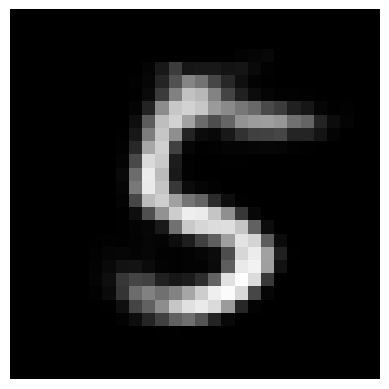

In [42]:
import matplotlib.pyplot as plt

img7 = model.generate_images(5, prior_std=1.0)
plt.imshow(img7.squeeze().cpu().numpy(), cmap='gray')
plt.axis('off')
plt.show()